# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [1]:
import sys
import os
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from high_level_DL_method import load_optimizer_and_scheduler
from dl_models.full_model import full_model
from trainer import Trainer
from examples.train_model_on_k_fold_validation import load_configuration
from K_fold_validation.K_fold_validation import KFoldSplitter
import numpy as np 
#trial_id = 'subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trial_id = 'subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322'
args,_ = load_configuration(trial_id,load_config=True)
if not hasattr(args,'horizon_step'):
    args.horizon_step = 1
args.K_fold = 2

folds =  list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,args = K_fold_splitter.split_k_fold()

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training and Hyper-parameter tuning with Ray is not possible

>>>> Load best CONFIG
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([940, 40, 7])

 Loading calendar inputs ...

>>>Tackle Contextual dataset:  subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
Restraining all datasets to train common dates: 2821 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 940 dates
kwargs_i: {'use_only_for

In [9]:
from examples.benchmark import local_get_args
dataset_for_coverage = ['subway_in','netmob_POIs'] 
model_name = 'STAEformer'
modification  = {'ray':True,
                'target_data' :'subway_in',
                'use_target_as_context': False,

                'batch_size':128,
                'grace_period':20,#20,
                'step_ahead':4,

                'evaluate_complete_ds' : True,
                'torch_compile':False,

                'temporal_graph_transformer_encoder': False, # False # True
                'compute_node_attr_with_attn' : False, # False # True

                'data_augmentation': False, #True,  #False
                'DA_method':'rich_interpolation', # 'noise' # 'interpolation

                'K_fold': 2,
                
                'dataset_names': ['subway_in','calendar','netmob_POIs'],
                'loss_function_type':'HuberLoss',
                'optimizer': 'adamw',
                'adaptive_embedding_dim': 32,
                'input_embedding_dim': 12,
                'tod_embedding_dim': 6,
                'dow_embedding_dim': 6,
                'feed_forward_dim': 256,
                
                'num_heads': 4,
                'num_layers': 3,

                'use_mixed_proj': True,
                'freq': '15min',
                'H':6,
                'D':1,
                'W':0,

                'input_embedding_dim': 24,
                'contextual_kwargs' : {'netmob_POIs': {'compute_node_attr_with_attn':True, 
                                                            'stacked_contextual': True,
                                                            'NetMob_selected_apps' : ['Deezer','Google_Maps'], # Google_Maps # 
                                                            'NetMob_transfer_mode' :  ['DL'], #,'UL'] # ['DL'] # ['UL'] #['DL','UL']
                                                            'NetMob_selected_tags' : ['iris'],#['iris','stadium','station','university']#['park','stadium','university','station','shop','nightclub','parkings','theatre','iris','transit','public_transport']
                                                            'NetMob_expanded' : '', # '' # '_expanded'
                                                            'NetMob_only_epsilon': False, # if True then look at NetMob data in InputsEpsilon instead of Input:  '/POIs/netmob_POI_Lyon{args.NetMob_expanded}/InputsEpsilon/{id_station}'
                                                            'vision_model_name' : None,
                                                            'use_only_for_common_dates': False, # If True then only use the dataset to restrain Feature vector to the common dates between the datasets
                                                            'attn_kwargs': {'latent_dim' : 2 ,
                                                                            'dim_feedforward' : 64,
                                                                            'num_heads' : 2 ,
                                                                            'dim_model' : 64
                                                                            }  
                                                            #'H' : ,
                                                            #'D': ,
                                                            #'W': , 
                                                },
                                        },  
                    'denoising_names':['netmob_POIs'],
                    'denoiser_names':["exponential"],   # ['median'], ['exponential'], ['savitzky_golay']         # un seul filtre
                    'denoising_modes':["train","valid","test"],             # par défaut
                    'denoiser_kwargs':{'exponential': {'alpha': 0.8}}, # {'savitzky_golay': {'window': 5, 'poly': 2}} # {'exponential': {'alpha':0.3}} # {"median": {"kernel_size": 2}}
}

args = local_get_args(model_name,
                    args_init = None,
                    dataset_names=modification['dataset_names'],
                    dataset_for_coverage=dataset_for_coverage,
                    modification =modification
                    )
args.calendar_types = ['dayofweek', 'timeofday']

K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,_ = K_fold_splitter.split_k_fold()

# Train on the first fold: 
subway_ds = K_subway_ds[0]

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar inputs ...

>>>Tackle Contextual dataset:  netmob_POIs
Netmob_T.size():  torch.Size([7392, 860])
Restraining all datasets to train common dates: 2819 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 939 dates
kwargs_i: {'compute_node_attr_with_attn': True, 'stacked_contextual': True, 'NetMob_selected_apps': ['Deezer', 'Google_Maps'], 'NetMob_transfer_mode': ['DL'], 'NetMob

Number of Training sequences:  1764
Total number of Init Validation/ Testing sequences: 940 / 938
Total number of Init Training sequences:  2364


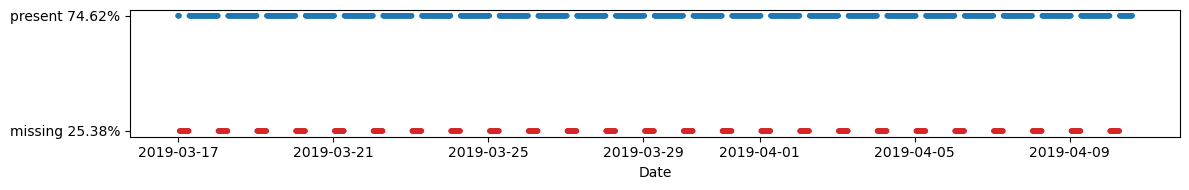

Number of Training sequences:  2819
Total number of Init Validation/ Testing sequences: 940 / 939
Total number of Init Training sequences:  4356


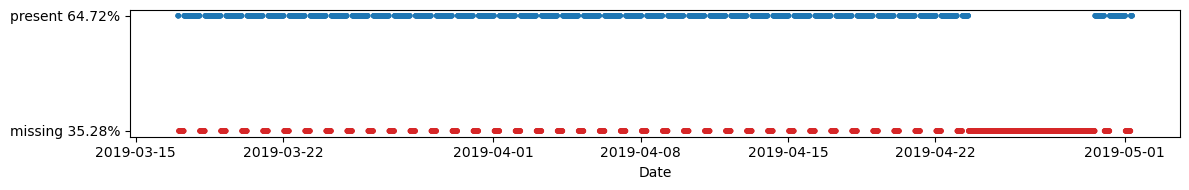

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
# Re-sample à un intervalle de 15 minutes

def plot_missing_dates(serie, freq='15T',valid_serie= None,testing_serie=None):
    print('Number of Training sequences: ', len(serie))
    print(f'Total number of Init Validation/ Testing sequences: {len(valid_serie)} / {len(testing_serie)}')
    serie = pd.Series(pd.to_datetime(serie)).dropna().sort_values()
    full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
    present_mask = full_index.isin(serie)
    print('Total number of Init Training sequences: ', len(full_index))

    colors = ['tab:blue' if p else 'tab:red' for p in present_mask]
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.scatter(full_index, present_mask.astype(int), c=colors, s=8)
    ax.set_yticks([0, 1])
    ax.set_yticklabels([f"missing {'{:.2%}'.format(1-len(serie)/len(full_index))}", f"present {'{:.2%}'.format(len(serie)/len(full_index))}"])
    ax.set_xlabel('Date')
    plt.tight_layout()
    plt.show()


dates_train_fold0 = subway_ds.tensor_limits_keeper.df_verif_train.iloc[:,-1]
dates_train_fold1 = K_subway_ds[-1].tensor_limits_keeper.df_verif_train.iloc[:,-1]

dates_valid_fold0 = subway_ds.tensor_limits_keeper.df_verif_valid.iloc[:,-1]
dates_valid_fold1 = K_subway_ds[-1].tensor_limits_keeper.df_verif_valid.iloc[:,-1]

dates_test_fold0 = subway_ds.tensor_limits_keeper.df_verif_test.iloc[:,-1]
dates_test_fold1 = K_subway_ds[-1].tensor_limits_keeper.df_verif_test.iloc[:,-1]

for s,sv,st in zip([dates_train_fold0, dates_train_fold1],[dates_valid_fold0, dates_valid_fold1],[dates_test_fold0, dates_test_fold1]):
    plot_missing_dates(serie=s,freq= args.freq,valid_serie= sv, testing_serie=st)

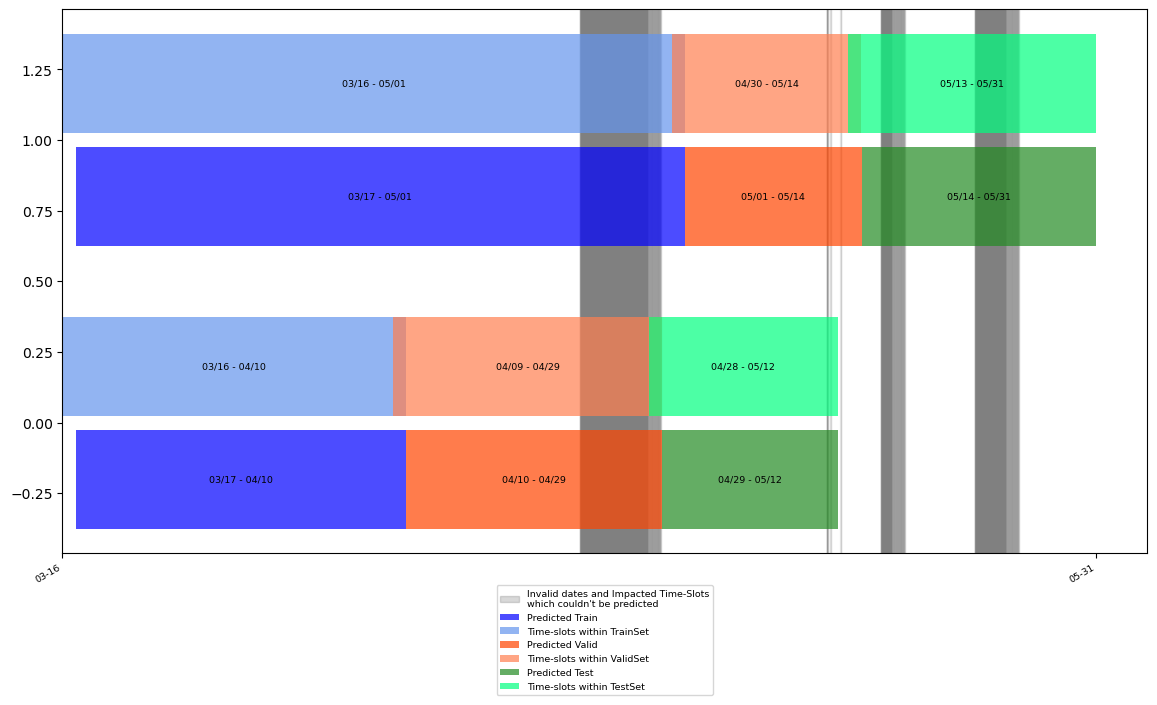

In [2]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates,figsize=(14,8))

## Train on the K-1 folds:

In [2]:
## Split the dataset already used for HP tuning and the others: 
ds_tuning = K_subway_ds[0]
ds_validation = K_subway_ds[1:]

## K-fold validation:
valid_losses = []
for fold,ds in enumerate(ds_validation):
    model = full_model(ds, args).to(args.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    valid_losses.append(trainer.performance['valid_loss'])

## Save Model: 
row = {f"fold{k}": [loss] for k,loss in enumerate(valid_losses)}
row.update({'mean' : [np.mean(valid_losses)]})
df_results = pd.DataFrame.from_dict(row)
df_results.to_csv(f"{SAVE_DIRECTORY}/{save_folder}/VALID_{trial_id}.csv")


NetMob Vision is NONE
Model size: 0.001GB

start training
epoch: 0 
 min\epoch : 0.05
Estimated time for training: 5.8min 


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


KeyboardInterrupt: 

## Check Number of predicted day in validation set: 

In [ ]:
for i in range(args.K_fold):
    dset = K_subway_ds[i]
    limits = dset.tensor_limits_keeper
    display(limits.df_verif_valid['t+0'].dt.date.value_counts())